# Setup

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random as random

from matplotlib import ticker
from concat_quoter_utc_toFeather import ConcatQuoterUtcToFeather

In [2]:
pd.options.display.float_format = '{:.1f}'.format # Tar bort vetenskaplig notation och ändrar till en decimal

## Load data from file

In [3]:
# Folder for binary df
folder_name = 'temp'
file_name = 'df.feather'
file_path = os.path.join(folder_name, file_name)

if not os.path.exists(file_path):
    create_feather_file = ConcatQuoterUtcToFeather(folder_name, file_name)
    create_feather_file.concat_quoter_utc()

In [4]:
feather_df = pd.read_feather(file_path)
print(feather_df.info(),end='\n\n')
print(feather_df.head(5),end='\n\n')
print(feather_df.describe(),end='\n\n')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94694400 entries, 2020-01-01 00:00:00+01:00 to 2022-12-31 23:59:59+01:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Value   float64
dtypes: float64(1)
memory usage: 1.4 GB
None

                           Value
Time                            
2020-01-01 00:00:00+01:00   49.9
2020-01-01 00:00:01+01:00   49.9
2020-01-01 00:00:02+01:00   49.9
2020-01-01 00:00:03+01:00   49.9
2020-01-01 00:00:04+01:00   49.9
           Value
count 94694400.0
mean        49.5
std          4.8
min         -1.0
25%         50.0
50%         50.0
75%         50.0
max         50.5


In [5]:
if 'Time' in feather_df.columns:
    feather_df.set_index('Time', inplace=True)
    print('Time set as index.')
    
if feather_df.index.tz is None:
    feather_df.index = feather_df.index.tz_localize('UTC', ambiguous='infer', nonexistent='shift_forward')
    print('Made time zone aware. Note: If your time was in the correct time zone, it may have been offset')

In [6]:
feather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94694400 entries, 2020-01-01 00:00:00+01:00 to 2022-12-31 23:59:59+01:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Value   float64
dtypes: float64(1)
memory usage: 1.4 GB


### Check data

Calculate the time difference in seconds between the dates to check if the amount of seconds is correct from the data

In [7]:
# Manually change this to check your data
date1 = pd.to_datetime('2020-01-01 00:00:00')
date2 = pd.to_datetime('2022-12-31 23:59:59')

time_difference_seconds = pd.date_range(start=date1, end=date2, freq='S').shape[0]
seconds_from_data = feather_df.count().sum()

if time_difference_seconds == seconds_from_data:
    result = f'The index range matches the data: {seconds_from_data}'
else:
    result = f'The index range dose not match the data: {seconds_from_data}'

print(f'Time difference index range is {time_difference_seconds}\n{result}')

Time difference index range is 94694400
The index range matches the data: 94694400


In [8]:
lower_bound = feather_df.index.min()
upper_bound = feather_df.index.max()

date_from = lower_bound.date()
date_to = upper_bound.date()

print(date_from,'\n',date_to)

2020-01-01 
 2022-12-31


### Fetch a random month, week or day from data

In [9]:
# Random Month
random_month = pd.to_datetime(random.uniform(lower_bound, upper_bound), unit='s').round('s')
start_of_month = random_month.replace(day=1, hour=0, minute=0, second=0)
end_of_month = (start_of_month + pd.offsets.MonthEnd()).replace(hour=23, minute=59, second=59)
random_month_data = feather_df[(feather_df.index >= start_of_month) & (feather_df.index <= end_of_month)]

# Random Week
random_week = pd.to_datetime(random.uniform(lower_bound, upper_bound), unit='s').round('s')
start_of_week = random_week - pd.to_timedelta((random_week.dayofweek + 7) % 7, unit='D')
start_of_week = start_of_week.replace(hour=0, minute=0, second=0)
end_of_week = start_of_week + pd.DateOffset(days=6, hours=23, minutes=59, seconds=59)
random_week_data = feather_df[(feather_df.index >= start_of_week) & (feather_df.index <= end_of_week)]

# Random Day
random_day = pd.to_datetime(random.uniform(lower_bound, upper_bound), unit='s').round('s')
start_of_day = random_day.replace(hour=0, minute=0, second=0)
end_of_day = random_day.replace(hour=23, minute=59, second=59)
random_day_data = feather_df[(feather_df.index >= start_of_day) & (feather_df.index <= end_of_day)]

# Print sample data
print(f'\nRandom Month Data:\n{random_month_data.index.min()}\n{random_month_data.index.max()}')
print(f'\nRandom Week Data:\n{random_week_data.index.min()}\n{random_week_data.index.max()}')
print(f'\nRandom Day Data:\n{random_day_data.index.min()}\n{random_day_data.index.max()}')


Random Month Data:
2020-09-01 00:00:00+02:00
2020-09-30 23:59:59+02:00

Random Week Data:
2022-04-04 00:00:00+02:00
2022-04-10 23:59:59+02:00

Random Day Data:
2022-07-29 00:00:00+02:00
2022-07-29 23:59:59+02:00


### Chose a date to fetch from data

In [10]:
from_date = '2022-10-22'
from_time = '00:00:00'
to_date = '2022-10-22'
to_time = '23:59:59'

from_dt = pd.to_datetime(f'{from_date} {from_time}').tz_localize('Europe/Stockholm')
to_dt = pd.to_datetime(f'{to_date} {to_time}').tz_localize('Europe/Stockholm')

chosen_time = feather_df[(feather_df.index >= from_dt) & (feather_df.index <= to_dt)]

print(chosen_time.head(2), end='\n\n')
print(chosen_time.tail(2), end='\n\n')

                           Value
Time                            
2022-10-22 00:00:00+02:00   50.0
2022-10-22 00:00:01+02:00   50.0

                           Value
Time                            
2022-10-22 23:59:58+02:00   50.0
2022-10-22 23:59:59+02:00   50.0


# Filtrering

Cell below is data to be filtered.
For full data: feather_df.copy()
For random month: random_month_data.copy()
For random week: random_week_data.copy()
For random day: random_day_data.copy()
For chosen date: chosen_time.copy()

In [11]:
df = feather_df.copy()

In [12]:
lower_bound = df.index.min()
upper_bound = df.index.max()

date_from = lower_bound.date()
date_to = upper_bound.date()

print(date_from,'\n',date_to)

2020-01-01 
 2022-12-31


In [13]:
disturbance_value_up = 50.1
disturbance_value_down = 49.9
df['deviation_up'] = df['Value'] > disturbance_value_up
df['deviation_down'] = (df['Value'] < disturbance_value_down) & (df['Value'] != -1)
df['deviation_up_count'] = df['deviation_up'].astype(int)
df['deviation_down_count'] = df['deviation_down'].astype(int)
df['deviation_up_duration'] = df['deviation_up_count'].groupby(df['deviation_up'].ne(df['deviation_up'].shift()).cumsum()).cumsum()
df['deviation_up_duration'] = df['deviation_up_duration'][df['deviation_up_duration'] != 0]
df['deviation_down_duration'] = df['deviation_down_count'].groupby(df['deviation_down'].ne(df['deviation_down'].shift()).cumsum()).cumsum()
df['deviation_down_duration'] = df['deviation_down_duration'][df['deviation_down_duration'] != 0]
df['hour'] = df.index.hour

Save/Load data filter

In [14]:
# folder_name = 'temp_df'
# file_name = 'chosen_time.feather'
# file_path = os.path.join(folder_name, file_name)

In [15]:
# df.to_feather(file_path)

In [16]:
# df = pd.read_feather(file_path)

Resample

In [17]:
# Count
disturbance_up_count_day = df['deviation_up_count'].resample('D').sum()
disturbance_up_count_week = df['deviation_up_count'].resample('W').sum()
disturbance_up_count_month = df['deviation_up_count'].resample('M').sum()
disturbance_up_count_yearly = df['deviation_up_count'].resample('Y').sum()

disturbance_down_count_day = df['deviation_down_count'].resample('D').sum()
disturbance_down_count_week = df['deviation_down_count'].resample('W').sum()

disturbance_down_count_month = df['deviation_down_count'].resample('M').sum()
disturbance_down_count_yearly = df['deviation_down_count'].resample('Y').sum()

# Duration
disturbance_up_duration_day = df['deviation_up_duration'].resample('D').mean()
disturbance_up_duration_week = df['deviation_up_duration'].resample('W').mean()
disturbance_up_duration_month = df['deviation_up_duration'].resample('M').mean()
disturbance_up_duration_hour = df.groupby('hour')['deviation_up_duration'].mean()

disturbance_down_duration_day = df['deviation_down_duration'].resample('D').mean()
disturbance_down_duration_week = df['deviation_down_duration'].resample('W').mean()
disturbance_down_duration_month = df['deviation_down_duration'].resample('M').mean()
disturbance_down_duration_hour = df.groupby('hour')['deviation_down_duration'].mean()

In [18]:
disturbance_up_count_week

Time
2020-01-05 00:00:00+01:00    3625
2020-01-12 00:00:00+01:00    6728
2020-01-19 00:00:00+01:00    4357
2020-01-26 00:00:00+01:00    6831
2020-02-02 00:00:00+01:00    3661
                             ... 
2022-12-04 00:00:00+01:00    2951
2022-12-11 00:00:00+01:00    2808
2022-12-18 00:00:00+01:00    6222
2022-12-25 00:00:00+01:00    4471
2023-01-01 00:00:00+01:00    9355
Freq: W-SUN, Name: deviation_up_count, Length: 157, dtype: int32

## Setup Seaborn

In [19]:
sns.set_theme(style="whitegrid")
cmap = sns.color_palette(n_colors=10, as_cmap=True)

# Graphs

## Disturbance Counts

### Yearly

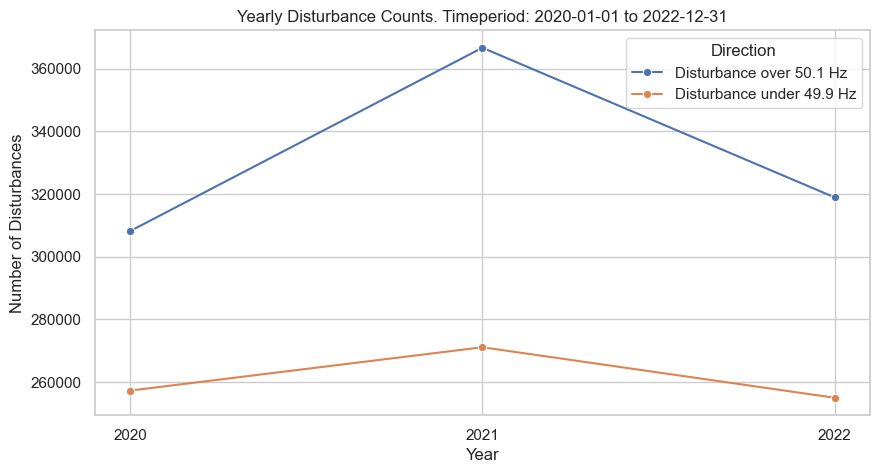

In [20]:
combined_data = pd.DataFrame({
    'Year': disturbance_down_count_yearly.index,
    f'Disturbance over {disturbance_value_up} Hz': disturbance_up_count_yearly.values,
    f'Disturbance under {disturbance_value_down} Hz': disturbance_down_count_yearly.values
})

df_long = pd.melt(combined_data, id_vars='Year', var_name='Direction', value_name='Count')

plt.figure(figsize=(10, 5))

sns.lineplot(x='Year', y='Count', hue='Direction', marker='o', data=df_long)

plt.xlabel('Year')
plt.xticks(disturbance_down_count_yearly.index, disturbance_down_count_yearly.index.year)

plt.ylabel('Number of Disturbances')

plt.title(f'Yearly Disturbance Counts. Timeperiod: {date_from} to {date_to}')

plt.show()

### Day, week, month

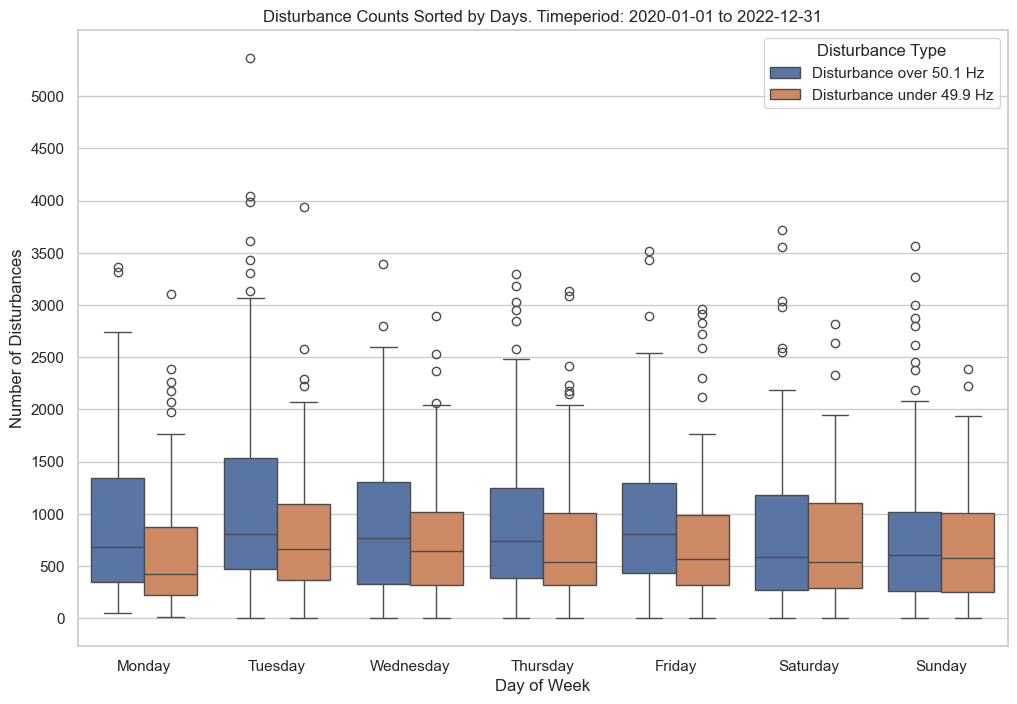

In [21]:
combined_data = pd.DataFrame({
    f'Disturbance over {disturbance_value_up} Hz': disturbance_up_count_day.values,
    f'Disturbance under {disturbance_value_down} Hz': disturbance_down_count_day.values
}, index=disturbance_up_count_day.index)

melted_data = combined_data.melt(var_name='Disturbance Type', value_name='Disturbance Count', ignore_index=False)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 8))

sns.boxplot(x=melted_data.index.day_name(), y='Disturbance Count', hue='Disturbance Type', data=melted_data, order=days_order)

plt.title(f'Disturbance Counts Sorted by Days. Timeperiod: {date_from} to {date_to}')

plt.xlabel('Day of Week')
plt.ylabel('Number of Disturbances')
plt.yticks(range(0, int(melted_data['Disturbance Count'].max()) + 1, 500))
plt.legend(title='Disturbance Type')

plt.show()

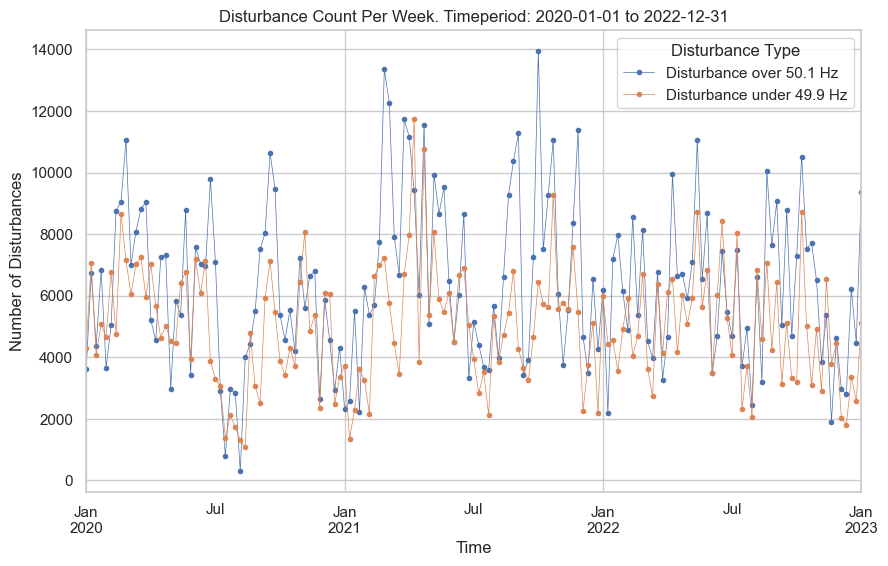

In [22]:
fig, axes = plt.subplots(figsize=(10, 6))
disturbance_up_count_week.plot(label=f'Disturbance over {disturbance_value_up} Hz', marker='.', linestyle='-', linewidth=0.5)
disturbance_down_count_week.plot(label=f'Disturbance under {disturbance_value_down} Hz', marker='.', linestyle='-', linewidth=0.5)

plt.title(f'Disturbance Count Per Week. Timeperiod: {date_from} to {date_to}')
plt.xlabel('Time')
plt.ylabel('Number of Disturbances')
plt.legend(title='Disturbance Type')
plt.show()

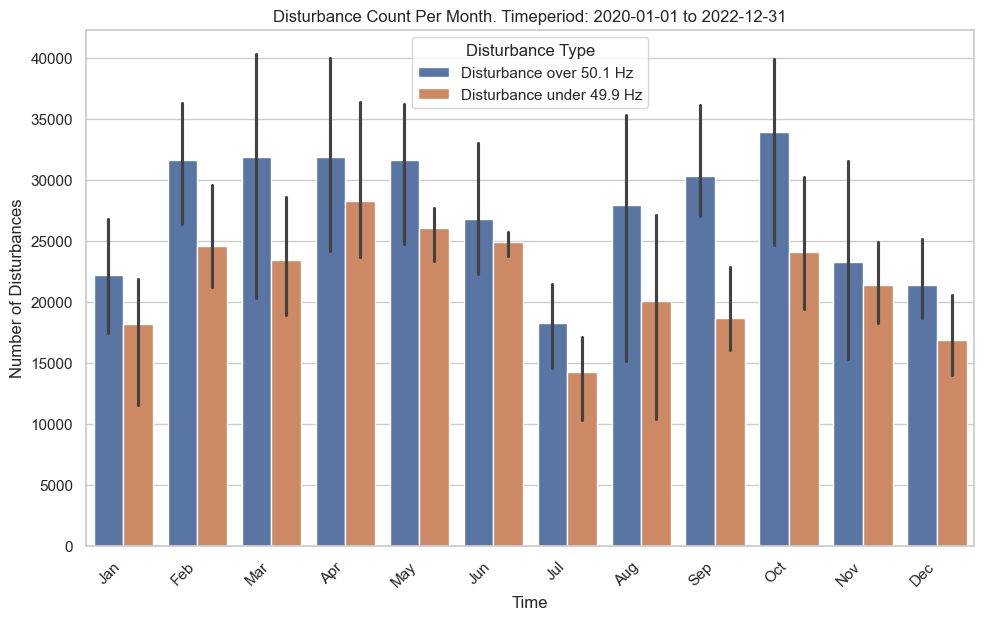

In [23]:
fig, axes = plt.subplots(figsize=(10, 6))

Months = {1: 'Jan',
          2: 'Feb',
          3: 'Mar',
          4: 'Apr',
          5: 'May',
          6: 'Jun',
          7: 'Jul',
          8: 'Aug',
          9: 'Sep',
          10: 'Oct',
          11: 'Nov',
          12: 'Dec'}

disturbance_count_month = pd.DataFrame({
    f'Disturbance over {disturbance_value_up} Hz': disturbance_up_count_month,
    f'Disturbance under {disturbance_value_down} Hz': disturbance_down_count_month
})

disturbance_count_month.index = disturbance_count_month.index.month
disturbance_count_month.index = disturbance_count_month.index.map(Months)

disturbance_count_month_melt = disturbance_count_month.melt(var_name='Disturbance Type', value_name='Disturbance Count', ignore_index=False)
sns.barplot(x=disturbance_count_month_melt.index, y=disturbance_count_month_melt['Disturbance Count'], data=disturbance_count_month_melt, hue='Disturbance Type')

plt.tight_layout()

plt.title(f'Disturbance Count Per Month. Timeperiod: {date_from} to {date_to}')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Disturbances')
plt.show()

## Disturbance Duration

All time

In [24]:
combined_data = pd.DataFrame({
    f'Disturbance over {disturbance_value_up} Hz': df['deviation_up_duration'].values,
    f'Disturbance under {disturbance_value_down} Hz': df['deviation_down_duration'].values
}, index=df.index)

print(combined_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94694400 entries, 2020-01-01 00:00:00+01:00 to 2022-12-31 23:59:59+01:00
Data columns (total 2 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Disturbance over 50.1 Hz   float64
 1   Disturbance under 49.9 Hz  float64
dtypes: float64(2)
memory usage: 2.1 GB
None


In [25]:
# combined_data.to_feather(r'.\temp\dist.feather')

In [26]:
# combined_data = pd.read_feather(r'.\temp\dist.feather')

In [27]:
nr_dist_under_1_seconds_up = df['deviation_up_duration'][df['deviation_up_duration'] <=1]
print(nr_dist_under_1_seconds_up.count())

nr_dist_under_2_over_1_seconds_up = df['deviation_up_duration'][(df['deviation_up_duration'] <= 2) & (df['deviation_up_duration'] > 1)]
print(nr_dist_under_2_over_1_seconds_up.count())

59727
50129


Number of disturbances reaching 20 min:

In [49]:
nr_dist_reaching_20min_up = df['deviation_up_duration'][df['deviation_up_duration'] >= 1200]
nr_dist_reaching_20min_down = df['deviation_down_duration'][df['deviation_down_duration'] >= 1200]

twenty_min = pd.DataFrame({
    '20_min_up_duration': nr_dist_reaching_20min_up.count(),
    '20_min_down_duration': nr_dist_reaching_20min_down.count()
}, index=['Deviation duration >= 20 min'])

twenty_min

,20_min_up_duration,20_min_down_duration
Deviation duration >= 20 min,639,0


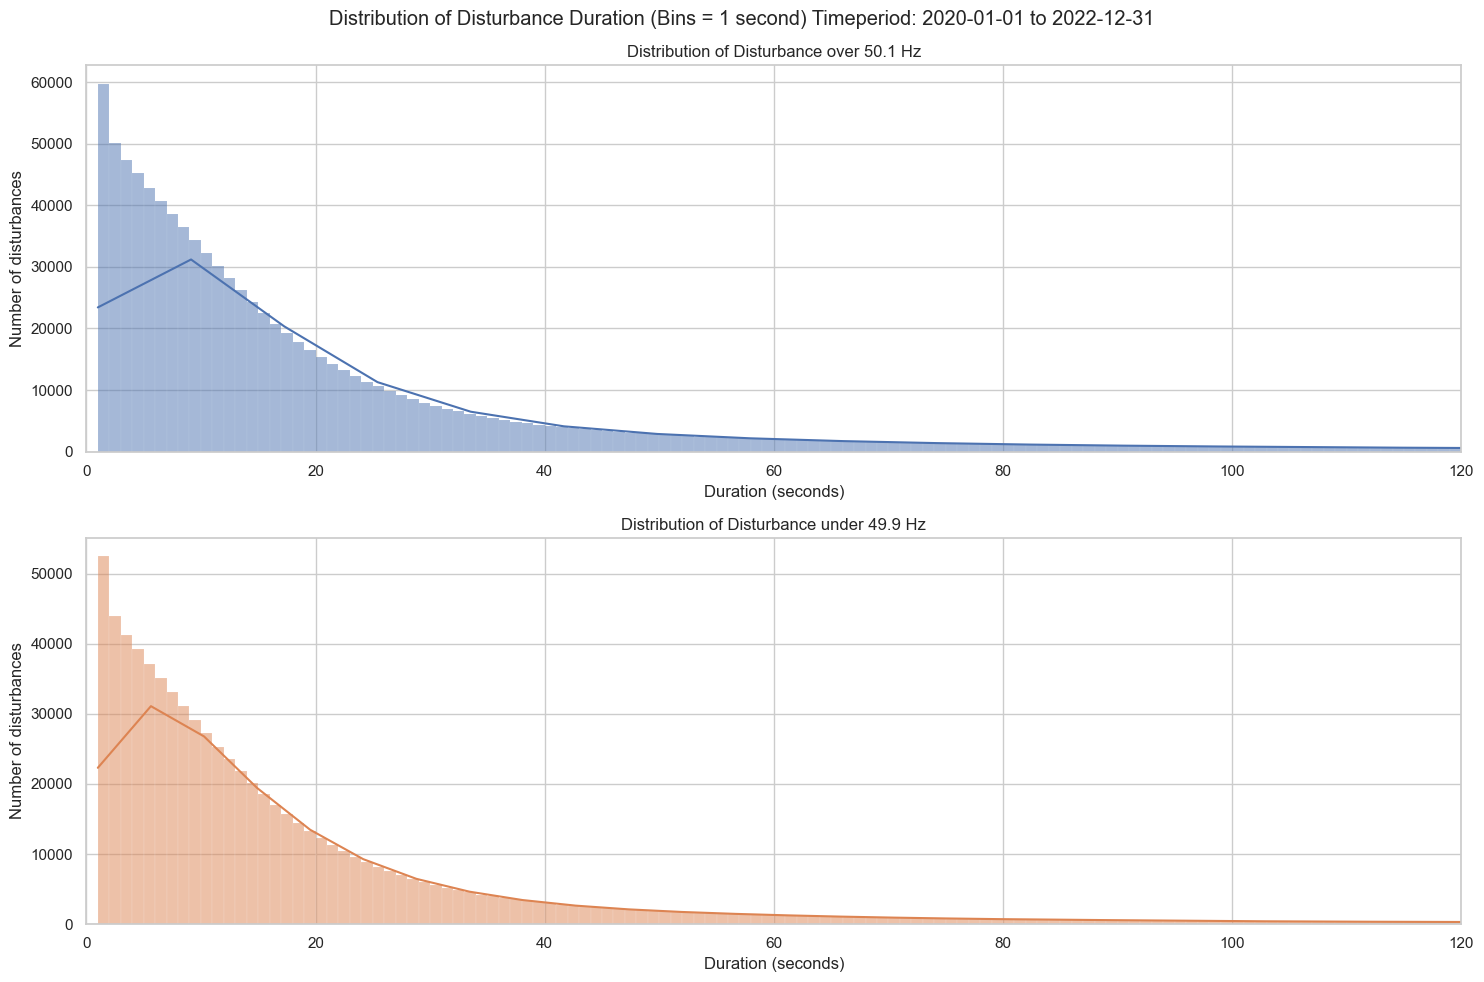

In [29]:
fig, axes = plt.subplots(2,1, figsize=(15, 10))

sns.histplot(data=combined_data, x=f'Disturbance over {disturbance_value_up} Hz', binwidth=1, kde=True, color=cmap[0], ax=axes[0])
axes[0].set_title(f'Distribution of Disturbance over {disturbance_value_up} Hz')
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Number of disturbances')
axes[0].set_xlim(0, 120)


sns.histplot(data=combined_data, x=f'Disturbance under {disturbance_value_down} Hz', binwidth=1, kde=True, color=cmap[1], ax=axes[1])
axes[1].set_title(f'Distribution of Disturbance under {disturbance_value_down} Hz')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Number of disturbances')
axes[1].set_xlim(0, 120)

plt.suptitle(f'Distribution of Disturbance Duration (Bins = 1 second) Timeperiod: {date_from} to {date_to}')
plt.ylabel('Number of disturbances')
plt.tight_layout()

plt.show()

### Day, week, month

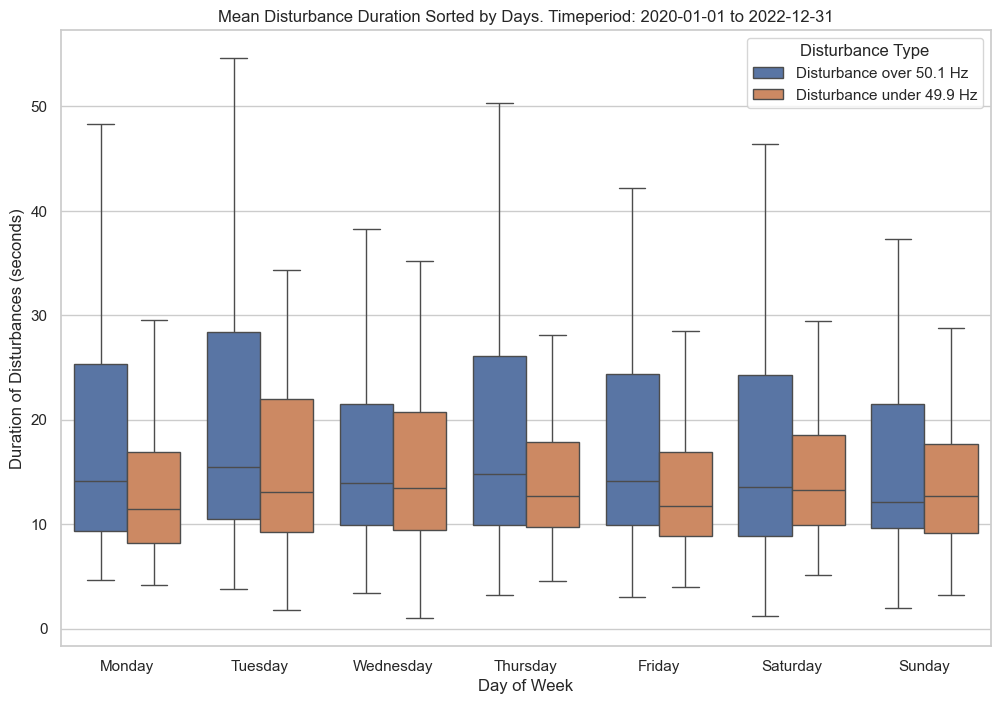

In [30]:
disturbance_duration_day_comb = pd.DataFrame({
    f'Disturbance over {disturbance_value_up} Hz': disturbance_up_duration_day.values,
    f'Disturbance under {disturbance_value_down} Hz': disturbance_down_duration_day.values
}, index=disturbance_down_duration_day.index)

disturbance_duration_day_melt = disturbance_duration_day_comb.reset_index().melt(id_vars='Time', var_name='Disturbance Type', value_name='Disturbance Duration', ignore_index=True)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 8))

sns.boxplot(x=disturbance_duration_day_melt['Time'].dt.day_name(), y='Disturbance Duration', hue='Disturbance Type', data=disturbance_duration_day_melt, order=days_order, showfliers = False)
    
plt.title(f'Mean Disturbance Duration Sorted by Days. Timeperiod: {date_from} to {date_to}')

plt.xlabel('Day of Week')
plt.ylabel('Duration of Disturbances (seconds)')
plt.legend(title='Disturbance Type')

plt.show()

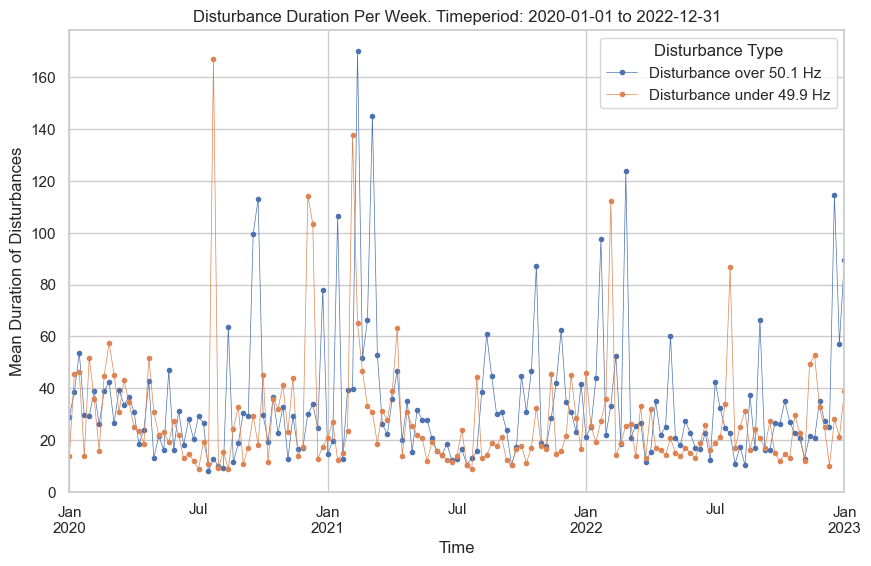

In [37]:
fig, axes = plt.subplots(figsize=(10, 6))
disturbance_up_duration_week.plot(label=f'Disturbance over {disturbance_value_up} Hz', marker='.', linestyle='-', linewidth=0.5)
disturbance_down_duration_week.plot(label=f'Disturbance under {disturbance_value_down} Hz', marker='.', linestyle='-', linewidth=0.5)

plt.title(f'Disturbance Duration Per Week. Timeperiod: {date_from} to {date_to}')
plt.xlabel('Time')
plt.ylabel('Mean Duration of Disturbances')
plt.legend(title='Disturbance Type')
plt.show()

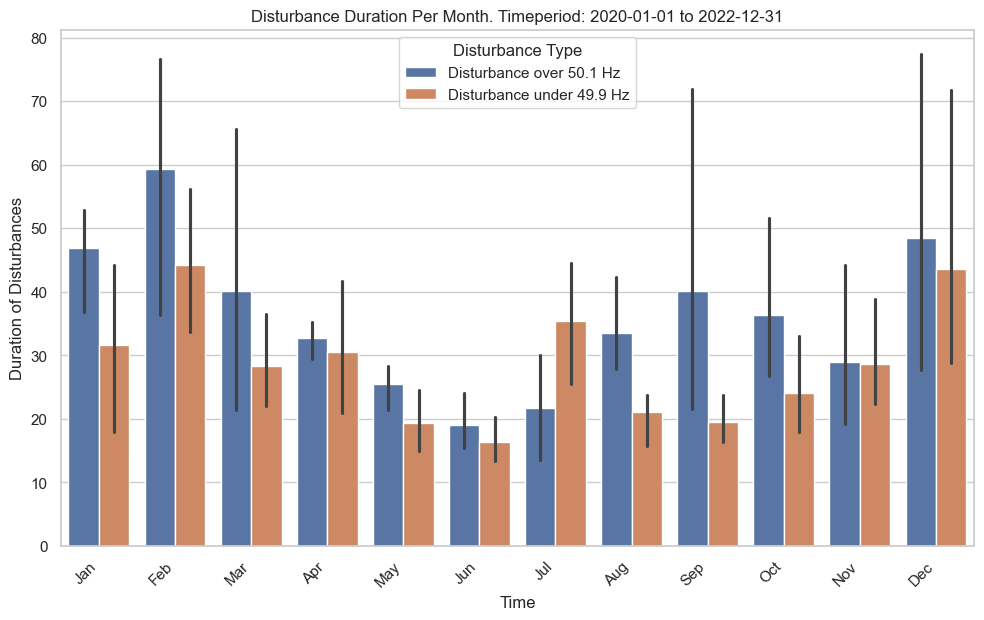

In [31]:
fig, axes = plt.subplots(figsize=(10, 6))

Months = {1: 'Jan',
          2: 'Feb',
          3: 'Mar',
          4: 'Apr',
          5: 'May',
          6: 'Jun',
          7: 'Jul',
          8: 'Aug',
          9: 'Sep',
          10: 'Oct',
          11: 'Nov',
          12: 'Dec'}

disturbance_duration_month = pd.DataFrame({
    f'Disturbance over {disturbance_value_up} Hz': disturbance_up_duration_month,
    f'Disturbance under {disturbance_value_down} Hz': disturbance_down_duration_month
})

disturbance_duration_month.index = disturbance_duration_month.index.month
disturbance_duration_month.index = disturbance_duration_month.index.map(Months)

disturbance_duration_month_melt = disturbance_duration_month.melt(var_name='Disturbance Type', value_name='Disturbance Duration', ignore_index=False)
sns.barplot(x=disturbance_duration_month_melt.index, y=disturbance_duration_month_melt['Disturbance Duration'], data=disturbance_duration_month_melt, hue='Disturbance Type')

plt.tight_layout()

plt.title(f'Disturbance Duration Per Month. Timeperiod: {date_from} to {date_to}')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Duration of Disturbances')
plt.show()

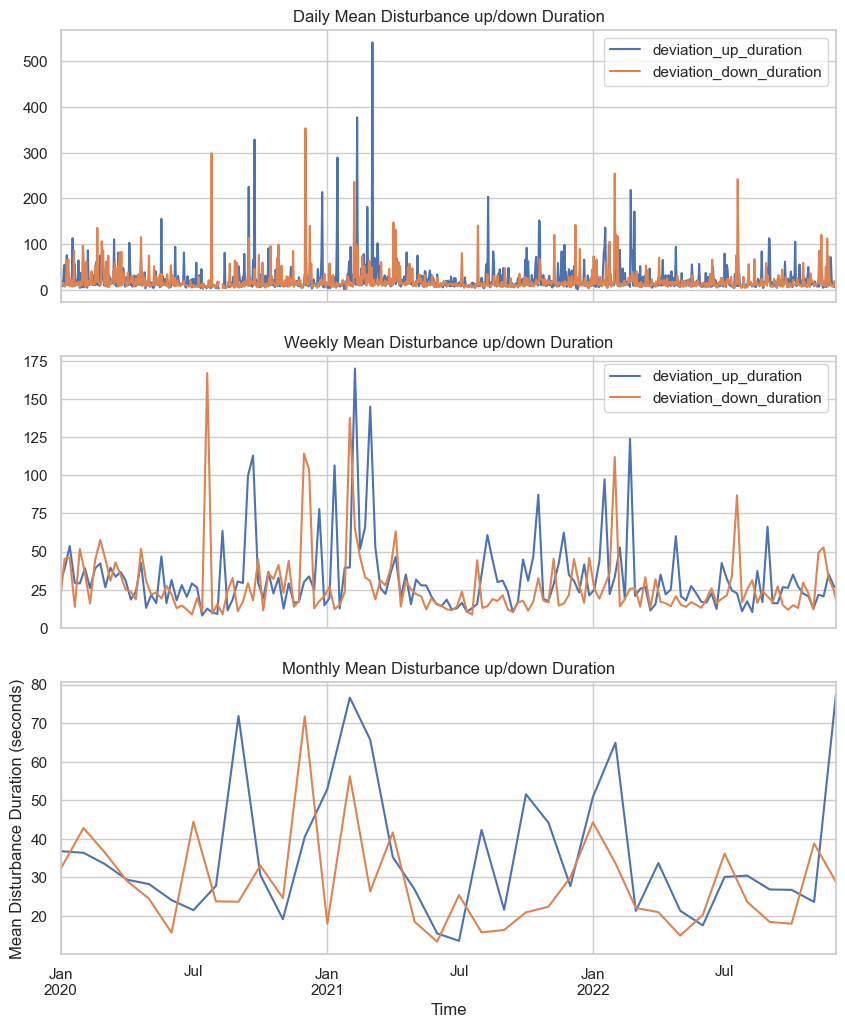

In [32]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

disturbance_up_duration_day.plot(ax=axes[0], title='Daily Mean Disturbance up/down Duration')
disturbance_down_duration_day.plot(ax=axes[0])
disturbance_up_duration_week.plot(ax=axes[1], title='Weekly Mean Disturbance up/down Duration')
disturbance_down_duration_week.plot(ax=axes[1],)
disturbance_up_duration_month.plot(ax=axes[2], title='Monthly Mean Disturbance up/down Duration')
disturbance_down_duration_month.plot(ax=axes[2])

axes[0].legend()
axes[1].legend()

plt.xlabel('Time')
plt.ylabel('Mean Disturbance Duration (seconds)')
plt.show()

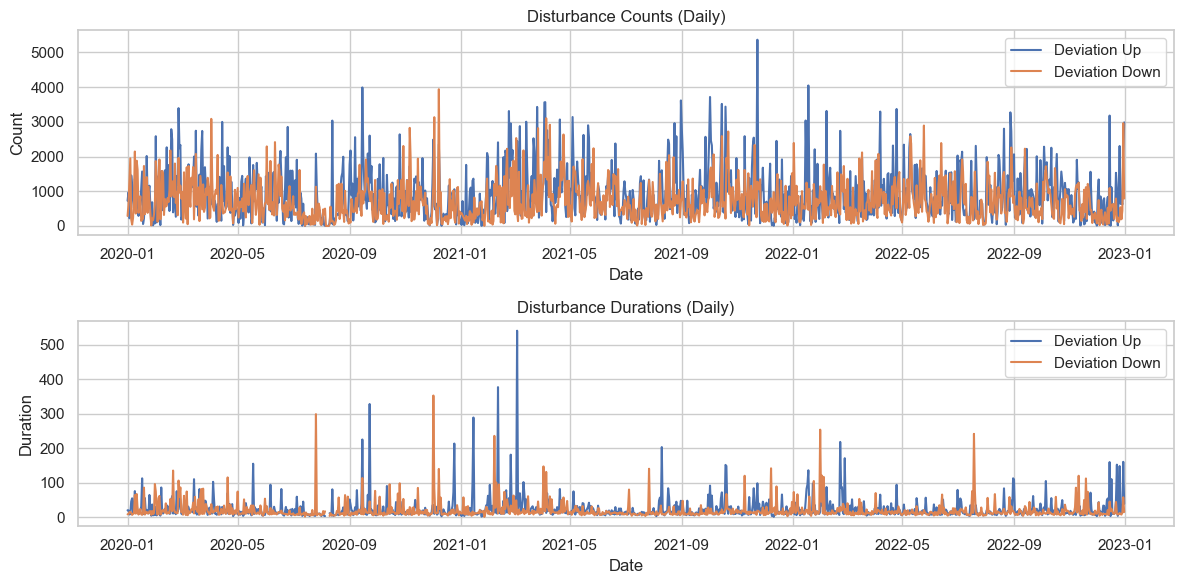

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(disturbance_up_count_day.index, disturbance_up_count_day, label='Deviation Up')
plt.plot(disturbance_down_count_day.index, disturbance_down_count_day, label='Deviation Down')
plt.title('Disturbance Counts (Daily)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(disturbance_up_duration_day.index, disturbance_up_duration_day, label='Deviation Up')
plt.plot(disturbance_down_duration_day.index, disturbance_down_duration_day, label='Deviation Down')
plt.title('Disturbance Durations (Daily)')
plt.xlabel('Date')
plt.ylabel('Duration')
plt.legend()

plt.tight_layout()
plt.show()

### Hour

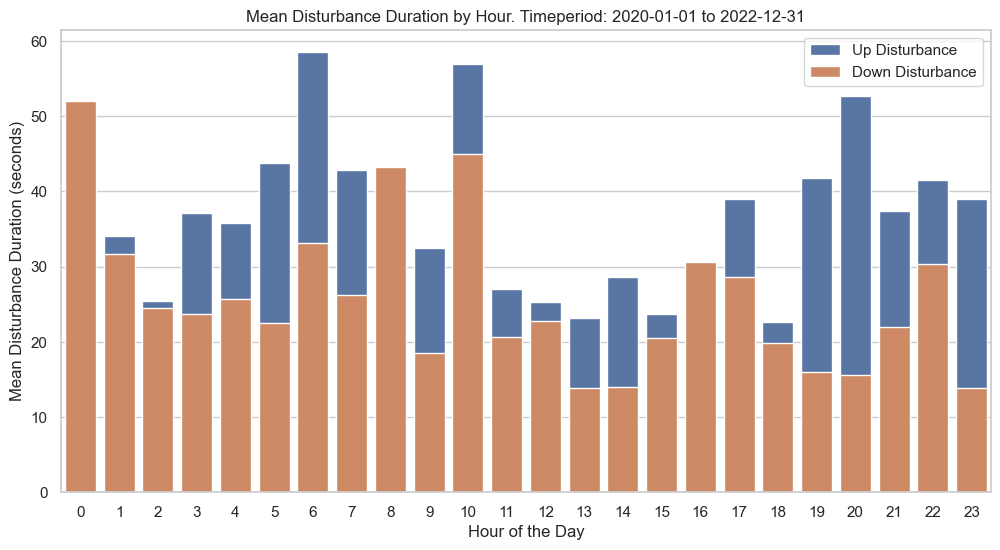

In [34]:
disturbance_duration_hour = df.groupby(['hour', 'deviation_up', 'deviation_down'])[['deviation_up_duration', 'deviation_down_duration']].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x='hour', y='deviation_up_duration', data=disturbance_duration_hour, label='Up Disturbance')
sns.barplot(x='hour', y='deviation_down_duration', data=disturbance_duration_hour, label='Down Disturbance')

ax.set_title(f'Mean Disturbance Duration by Hour. Timeperiod: {date_from} to {date_to}')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Mean Disturbance Duration (seconds)')
ax.legend()

plt.show()


In [35]:
disturbance_duration_hour

,hour,deviation_up,deviation_down,deviation_up_duration,deviation_down_duration
0,0,False,False,NaN,NaN
1,0,False,True,NaN,52.0
2,0,True,False,29.2,NaN
3,1,False,False,NaN,NaN
4,1,False,True,NaN,31.7
...,...,...,...,...,...
67,22,False,True,NaN,30.3
68,22,True,False,41.5,NaN
69,23,False,False,NaN,NaN
70,23,False,True,NaN,13.8
